In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#Define constants
m = 39.95*1.68*10**(-27)
epsilon = 119.8/1.381*10**(-23)
sigma = 3.405 #angstrom
h = 10**-4 #Timestep, sqrt(m*sigma**2/epsilon)

#Potential function in natural units
def r(x,y):
    r_pos = np.sqrt(x**2+y**2)
    return r_pos

def Grad_potential(x_1, y_1, x_2, y_2):
    direction = np.array([[x_1 - x_2], [y_1 - y_2]])
    r = np.sqrt((x_1 - x_2)**2+(y_1 - y_2)**2)
    U_partial_r = -4*(6*(r)**(-7) - 12*(r)**(-13))
    grad_U = U_partial_r * direction *r**(-1)
    return grad_U

def boxcheck (x, y):
    x_upper_limit = 5.0 #units of sigma
    y_upper_limit = 5.0 #units of sigma
    
    x_lower_limit = 0
    y_lower_limit = 0
    
    l = x_upper_limit - x_lower_limit #length of the box, only works for squares
    
    if x < x_upper_limit and x > x_lower_limit:
        if y < y_upper_limit and y > y_lower_limit:
            return np.array([x, y])
        if y > y_upper_limit:
            return np.array([x, y -l])
        if y < y_lower_limit:
            return np.array([x, y +l])
    if x > x_upper_limit:
        if ( y < y_upper_limit and y > y_lower_limit):
            return np.array([x- l, y])
        if y > y_upper_limit:
            return np.array([x- l, y - l])
        if y < y_lower_limit:
            return np.array([x- l, y + l])
    if x < x_lower_limit:
        if ( y < y_upper_limit and y > y_lower_limit):
            return np.array([x + l, y])
        if y > y_upper_limit:
            return np.array([x + l, y - l])
        if y < y_lower_limit:
            return np.array([x + l, y + l])


        
#Class for argon particles
        
class Particle:
    
    mass = 39.95*1.68*10**(-27)
    def __init__(self, x, y, vx, vy):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy

class Energy:
    def __init__(self, E_tot, E_kin, E_pot):
        self.E_tot = E_tot
        self.E_kin = E_kin
        self.E_pot = E_pot
        


In [3]:
# Loop to initialize the particles

#Using natural units
n_particles = 5
L = 5.0 # length of box

particles = []

energy = []
E_kin_initial = np.array([0.0])
E_pot_initial = np.array([0.0])

for i in range(n_particles):
    
    x = random.uniform(0, 5.0) #sigma
    y = random.uniform(0, 5.0) #sigma
    position = np.array([[x],[y]])

    vx = random.uniform(-1.0, 1.0) #sqrt(epsilon/m)
    vy = random.uniform(-1.0, 1.0) #sqrt(epsilon/m)
    velocity = np.array([[vx],[vy]])
    particle = Particle(position[0], position[1], velocity[0], velocity[1])
    particles.append(particle)
    E_kin_initial += 0.5*(vx**2+vy**2)


energy_initial  = Energy(E_kin_initial+E_pot_initial,E_kin_initial,E_pot_initial)
energy.append(energy_initial)
    
particles_array = np.array(particles)
energy_array = np.array(energy)

In [4]:
timesteps = 10000

for i in range(timesteps): #after each step i the particles will move
    #Store the energies per particle
    E_kin_particles = n_particles*[0]
    E_pot_particles = n_particles*[0]

    for j in range(n_particles): #finding the new values of velocity and position for each particle j
        total_acceleration_x = 0
        total_acceleration_y = 0
        

        for k in range(n_particles): #evaluating the net force acting on the particle j from the interacion with all other particles
            if k != j:
                acceleration = Grad_potential(particles_array[j].x[-1], particles_array[j].y[-1], 
                                              (particles_array[j].x[-1] - particles_array[k].x[-1] + L/2) % L - L/2, 
                                              (particles_array[j].y[-1] - particles_array[k].y[-1] + L/2) % L - L/2)
                total_acceleration_x += acceleration[0]
                total_acceleration_y += acceleration[1]
        
        new_x = particles_array[j].x[-1] + particles_array[j].vx[-1]*h + h**2/2*total_acceleration_x
        new_y = particles_array[j].y[-1] + particles_array[j].vy[-1]*h + h**2/2*total_acceleration_y
        
        particles[j].x = np.append(particles_array[j].x, boxcheck(new_x, new_y)[0])
        particles[j].y = np.append(particles_array[j].y, boxcheck(new_x, new_y)[1])

        
        old_total_acceleration_x = 0
        old_total_acceleration_y = 0
        

        for k in range(n_particles): #evaluating the net force acting on the particle j from the interacion with all other particles
            if k != j:
                old_acceleration = Grad_potential(particles_array[j].x[-1], particles_array[j].y[-1], 
                                                  (particles_array[j].x[-1] - particles_array[k].x[-1] + L/2) % L - L/2,
                                                  (particles_array[j].y[-1] - particles_array[k].y[-1] + L/2) % L - L/2)
                old_total_acceleration_x += old_acceleration[0]
                old_total_acceleration_y += old_acceleration[1]
        
        new_vel_x = particles_array[j].vx[-1] +h/2 * (total_acceleration_x + old_total_acceleration_x)
        new_vel_y = particles_array[j].vy[-1] +h/2 * (total_acceleration_y + old_total_acceleration_y)
        
        
        particles[j].vx = np.append(particles_array[j].vx, new_vel_x)
        particles[j].vy = np.append(particles_array[j].vy, new_vel_y)


        #Determine the different energies per particle
        E_kin_particles[j]=(0.5*(new_vel_x[0]**2+new_vel_y[0]**2))
        E_pot_particles[j]=(total_acceleration_x[0]+total_acceleration_y[0])

    #sum the energies of all particles to get the total energies
    E_kin_new = sum(E_kin_particles)
    E_pot_new = sum(E_pot_particles)
    E_tot_new = E_kin_new + E_pot_new
    
    energy[0].E_kin = np.append(energy_array[0].E_kin, E_kin_new)   
    energy[0].E_tot = np.append(energy_array[0].E_tot, E_tot_new)
    energy[0].E_pot = np.append(energy_array[0].E_pot, E_pot_new)


(0, 5.0)

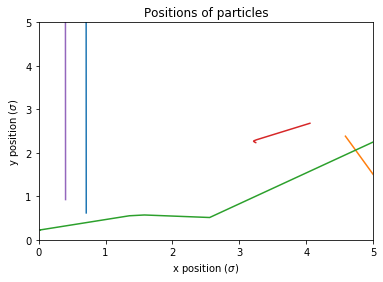

In [5]:
for i in range(n_particles):
    plt.plot(particles_array[i].x, particles_array[i].y)
plt.title("Positions of particles")
plt.xlabel("x position ($\sigma$)")
plt.ylabel("y position ($\sigma$)")
plt.xlim(0,L)
plt.ylim(0,L)


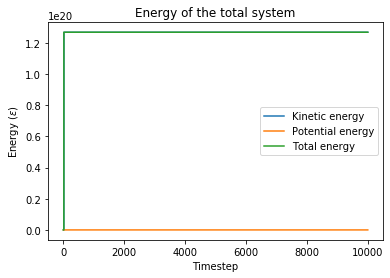

In [6]:
plt.plot(np.arange(timesteps+1), energy_array[0].E_kin, label = 'Kinetic energy')
plt.plot(np.arange(timesteps+1), energy_array[0].E_pot, label = 'Potential energy')
plt.plot(np.arange(timesteps+1), energy_array[0].E_tot, label = 'Total energy')
plt.title("Energy of the total system")
plt.xlabel("Timestep")
plt.ylabel("Energy ($\epsilon$)")
plt.legend()
plt.show()